## response of MLD to wind forcing

In [69]:
import xarray as xr
import glob
import numpy as np
import netCDF4 as nc
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from cmocean import cm
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/WORK_SCRIPTS')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
import scendict as sc

In [70]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [71]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

In [ ]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

so_csize = (tmesh['csize'][0:37,:].values)
so_csize_broad = np.zeros([365*10, 37, 182])

for i in range(0,365*10):
    so_csize_broad[i,:,:] = so_csize

In [83]:
horse = False

if horse:
    tms = ['TOM12_TJ_1ASA','TOM12_TJ_1BSA', 'TOM12_TJ_3ASA', 'TOM12_TJ_3BSA',\
              'TOM12_TJ_2ASA', 'TOM12_TJ_2BSA']
    mld_ar = np.zeros([6,151,12])

    for r in range(0,6):
        baseDir = '/gpfs/data/greenocean/software/runs//'
        tr = tms[r]
        print(tr)
        ylist = make_yearlist(1950,2100,'grid_T', tr, baseDir)
        w = xr.open_mfdataset(ylist)

        for i in range(0,151):
            year = i + 1950
            tmld = w.mldkz5.sel(time_counter=w.time_counter.dt.year.isin([year])).values[0:12,22:32,:]
            mask = so_csize_broad[0:12,22:32,:]
            mld = np.average(np.average(tmld, weights = mask, axis = 2), axis = 1)
            mld_ar[r,i,:] = mld

In [84]:
import pickle
#pickle.dump(mld_ar, open("6scen_mld.pkl", 'wb'))
mld_ar = pickle.load(open('./6scen_mld.pkl', 'rb'))


In [85]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


In [86]:
cols = [sc.scen['1A']['color'],\
        sc.scen['1B']['color'],\
        sc.scen['3A']['color'],\
        sc.scen['3B']['color'],\
        sc.scen['2A']['color'],\
        sc.scen['2B']['color'],\
        'grey', 'g', 'b'] 

summer_mld = (mld_ar[:,:,0]*31+mld_ar[:,:,1]*28+mld_ar[:,:,11]*30)/(31+30+28)
autumn_mld = (mld_ar[:,:,2]*31+mld_ar[:,:,3]*30+mld_ar[:,:,4]*31)/(92)
winter_mld = (mld_ar[:,:,5]*30+mld_ar[:,:,6]*31+mld_ar[:,:,7]*31)/(92)
spring_mld = (mld_ar[:,:,8]*30+mld_ar[:,:,9]*31+mld_ar[:,:,10]*30)/(92)



Text(0.5, 1, 'Mixed layer depth (mldkz5), m, seas. avg. -64N - -54N')

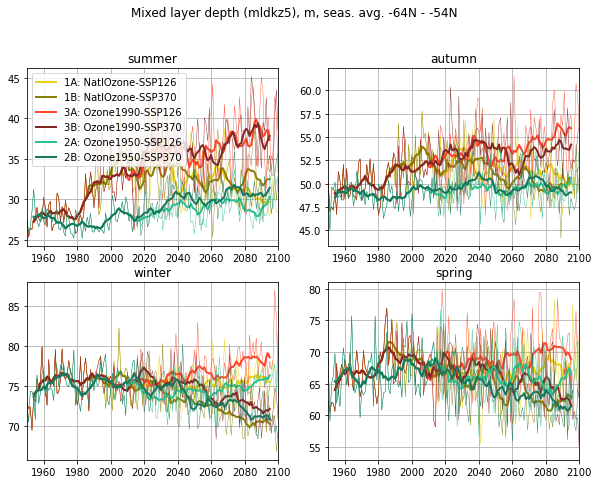

In [87]:
fact = 0.45
fig, axs = plt.subplots(2,2, figsize=(22*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
labs_s = ['1A: NatlOzone-SSP126', '1B: NatlOzone-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370',
          '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370',]

tits = ['summer','autumn','winter','spring']
for i in range(0,6):
    axs[0].plot(np.arange(1950,2101,1),summer_mld[i,:], color =  cols[i], linewidth = 0.4)
    axs[0].plot(np.arange(1954,2096,1),moving_average(summer_mld[i,:],10), color =  cols[i], linewidth = 2,
               label = labs_s[i])
    axs[1].plot(np.arange(1950,2101,1),autumn_mld[i,:], color =  cols[i], linewidth = 0.4)
    axs[1].plot(np.arange(1954,2096,1),moving_average(autumn_mld[i,:],10), color =  cols[i], linewidth = 2)
    axs[2].plot(np.arange(1950,2101,1),winter_mld[i,:], color =  cols[i], linewidth = 0.4)
    axs[2].plot(np.arange(1954,2096,1),moving_average(winter_mld[i,:],10), color =  cols[i], linewidth = 2)
    axs[3].plot(np.arange(1950,2101,1),spring_mld[i,:], color =  cols[i], linewidth = 0.4)
    axs[3].plot(np.arange(1954,2096,1),moving_average(spring_mld[i,:],10), color =  cols[i], linewidth = 2)
    
for i in range(0,4):
    axs[i].set_title(tits[i])
    axs[i].grid()
    axs[i].set_xlim([1950,2100])
    axs[0].legend(loc = 'best')
plt.suptitle('Mixed layer depth (mldkz5), m, seas. avg. -64N - -54N', y =1)


array([26.92170574, 32.29060743, 41.37144789, 49.33027845, 59.67337266,
       64.55001877, 75.79701801, 78.22649482, 79.34873922, 67.52143323,
       41.681022  , 23.63984141])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1, 'Mixed layer depth (mldkz5), seasonal cycle -64N - -54N')

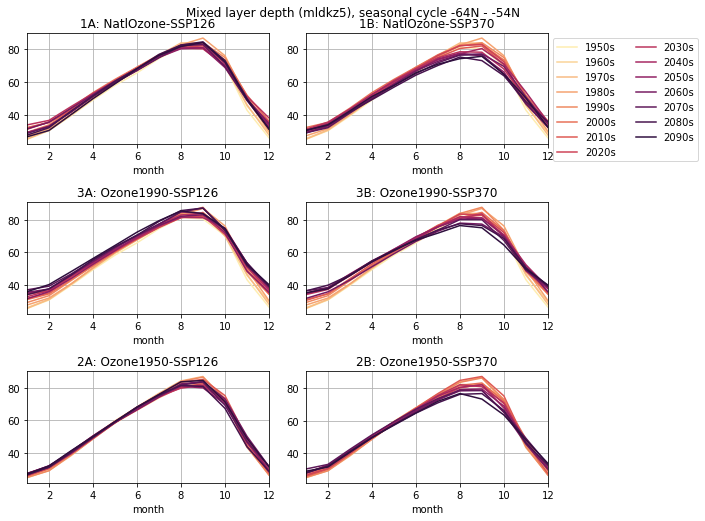

In [110]:
fact = 0.45
fig, axs = plt.subplots(3,2, figsize=(22*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
labs_s = ['1A: NatlOzone-SSP126', '1B: NatlOzone-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370',
          '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370',]
tcm = cm.matter
tits = ['summer','autumn','winter','spring']
for i in range(0,15):
    ind = i*10
    tyr = 1950+ind;
    tyr2 = tyr+10
    for r in range(0,6):
        tmld = np.nanmean(mld_ar[r,ind:ind+10,:], axis = 0)
        
        axs[r].plot(np.arange(1,13,1), tmld, color = tcm(1.*(i)/14), label = f'{tyr}s')
        axs[r].set_title(f'{labs_s[r]}')
        axs[1].legend(ncol = 2, bbox_to_anchor = [1,1])
        axs[r].grid()
        axs[r].set_xlim([1,12])
        axs[r].set_xlabel('month')

plt.tight_layout()
plt.suptitle('Mixed layer depth (mldkz5), seasonal cycle -64N - -54N', y =1)
